In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2025-02-20 05:57:24.624554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
%%markdown
## Computing gradients
To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients.

## Computing gradients
To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients.


In [4]:
%%markdown
### Gradient tapes
TensorFlow provides the `tf.GradientTape` API for automatic differentiation;
that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variables`.
TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape".
TensorFlow then uses that tape to compute the gradients of a "recorded" computation using `reverse mode differentiation`.

### Gradient tapes
TensorFlow provides the `tf.GradientTape` API for automatic differentiation;
that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variables`.
TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape".
TensorFlow then uses that tape to compute the gradients of a "recorded" computation using `reverse mode differentiation`.


In [5]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

In [6]:
%%markdown
To get the gradient of loss with respect to both variables, you can pass both as sources to the gradient method.
The tape is flexible about how sources are passed and will accept any nested combination of lists or dictionaries
and return the gradient structured the same way (see `tf.nest`).

To get the gradient of loss with respect to both variables, you can pass both as sources to the gradient method.
The tape is flexible about how sources are passed and will accept any nested combination of lists or dictionaries
and return the gradient structured the same way (see `tf.nest`).


In [7]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

In [14]:
%%markdown
The gradient with respect to each source has the shape of the source:

The gradient with respect to each source has the shape of the source:


In [15]:
print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


In [16]:
%%markdown
Here is the gradient calculation again, this time passing a dictionary of variables:

Here is the gradient calculation again, this time passing a dictionary of variables:


In [17]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.52008176,  1.1025016 ], dtype=float32)>

In [24]:
%%markdown
## Gradients with respect to a model

It's common to collect `tf.Variables` into a `tf.Module` or one of its subclasses (`layers.Layer`, `keras.Model`) for checkpointing and exporting.

In most cases, you will want to calculate gradients with respect to a model's trainable variables.
Since all subclasses of `tf.Module` aggregate their variables in the `Module.trainable_variables` property,
you can calculate these gradients in a few lines of code:

## Gradients with respect to a model

It's common to collect `tf.Variables` into a `tf.Module` or one of its subclasses (`layers.Layer`, `keras.Model`) for checkpointing and exporting.

In most cases, you will want to calculate gradients with respect to a model's trainable variables.
Since all subclasses of `tf.Module` aggregate their variables in the `Module.trainable_variables` property,
you can calculate these gradients in a few lines of code:


In [22]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)
grad

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 3.5541344,  5.517792 ],
        [ 7.1082687, 11.035584 ],
        [10.662403 , 16.553377 ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.5541344, 5.517792 ], dtype=float32)>]

In [23]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

dense_3/kernel:0, shape: (3, 2)
dense_3/bias:0, shape: (2,)


In [26]:
%%markdown
## Controlling what the tape watches
The default behavior is to record all operations after accessing a trainable `tf.Variable`. The reasons for this are:

- The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
- The tape holds references to intermediate outputs, so you don't want to record unnecessary operations.
- The most common use case involves calculating the gradient of a loss with respect to all a model's trainable variables.

For example, the following fails to calculate a gradient because the `tf.Tensor` is not "watched" by default,
and the `tf.Variable` is not trainable:

## Controlling what the tape watches
The default behavior is to record all operations after accessing a trainable `tf.Variable`. The reasons for this are:

- The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
- The tape holds references to intermediate outputs, so you don't want to record unnecessary operations.
- The most common use case involves calculating the gradient of a loss with respect to all a model's trainable variables.

For example, the following fails to calculate a gradient because the `tf.Tensor` is not "watched" by default,
and the `tf.Variable` is not trainable:


In [29]:
# A trainable variable
x0 = tf.Variable(3.0, name='v0')
# Not trainable
x1 = tf.Variable(3.0, name='v1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='v2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='v3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


In [31]:
%%markdown
You can list the variables being watched by the tape using the `GradientTape.watched_variables` method:

You can list the variables being watched by the tape using the `GradientTape.watched_variables` method:


In [32]:
[var.name for var in tape.watched_variables()]

['v0:0']

In [33]:
%%markdown
`tf.GradientTape` provides hooks that give the user control over what is or is not watched.

To record gradients with respect to a `tf.Tensor`, you need to call `GradientTape.watch(x)`:

`tf.GradientTape` provides hooks that give the user control over what is or is not watched.

To record gradients with respect to a `tf.Tensor`, you need to call `GradientTape.watch(x)`:


In [35]:
# A trainable variable
x0 = tf.Variable(3.0, name='v0')
# Not trainable
x1 = tf.Variable(3.0, name='v1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='v2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='v3')

with tf.GradientTape() as tape:
    tape.watch(x2) # Record gradient of a Tensor
    y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
tf.Tensor(6.0, shape=(), dtype=float32)
None


In [36]:
%%markdown
Conversely, to disable the default behavior of watching all `tf.Variables`,
set `watch_accessed_variables=False` when creating the gradient tape.
This calculation uses two variables, but only connects the gradient for one of the variables:

Conversely, to disable the default behavior of watching all `tf.Variables`,
set `watch_accessed_variables=False` when creating the gradient tape.
This calculation uses two variables, but only connects the gradient for one of the variables:


In [37]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1)
    y0 = tf.math.sin(x0)
    y1 = tf.nn.softplus(x1)
    y = y0 + y1
    ys = tf.reduce_sum(y)

In [38]:
%%markdown
Since `GradientTape.watch` was not called on x0, no gradient is computed with respect to it:

Since `GradientTape.watch` was not called on x0, no gradient is computed with respect to it:


In [39]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


In [40]:
%%markdown
## Intermediate results

You can also request gradients of the output with respect to intermediate values computed inside
the `tf.GradientTape` context.

## Intermediate results

You can also request gradients of the output with respect to intermediate values computed inside
the `tf.GradientTape` context.


In [41]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


In [42]:
%%markdown
## Gradients of non-scalar targets

A gradient is fundamentally an operation on a scalar.

## Gradients of non-scalar targets

A gradient is fundamentally an operation on a scalar.


In [43]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
    y0 = x ** 2
    y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


In [44]:
%%markdown
Thus, if you ask for the gradient of multiple targets, the result for each source is:

- The gradient of the sum of the targets, or equivalently
- The sum of the gradients of each target.

Thus, if you ask for the gradient of multiple targets, the result for each source is:

- The gradient of the sum of the targets, or equivalently
- The sum of the gradients of each target.


In [45]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
    y0 = x ** 2
    y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


In [46]:
%%markdown
Similarly, if the target(s) are not scalar the gradient of the sum is calculated:

Similarly, if the target(s) are not scalar the gradient of the sum is calculated:


In [47]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


In [49]:
%%markdown
This makes it simple to take the gradient of the sum of a collection of losses
, or the gradient of the sum of an element-wise loss calculation.

If you need a separate gradient for each item, refer to `Jacobians`.

In some cases you can skip the Jacobian. For an element-wise calculation
, the gradient of the sum gives the derivative of each element with respect to its input-element
, since each element is independent:

This makes it simple to take the gradient of the sum of a collection of losses
, or the gradient of the sum of an element-wise loss calculation.

If you need a separate gradient for each item, refer to `Jacobians`.

In some cases you can skip the Jacobian. For an element-wise calculation
, the gradient of the sum gives the derivative of each element with respect to its input-element
, since each element is independent:


In [51]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)
dy_dx

<tf.Tensor: shape=(201,), dtype=float32, numpy=
array([4.53958055e-05, 5.01696668e-05, 5.54454418e-05, 6.12759977e-05,
       6.77195421e-05, 7.48406237e-05, 8.27104086e-05, 9.14074990e-05,
       1.01019003e-04, 1.11640831e-04, 1.23379359e-04, 1.36351780e-04,
       1.50687614e-04, 1.66530372e-04, 1.84037970e-04, 2.03385585e-04,
       2.24766336e-04, 2.48393306e-04, 2.74502818e-04, 3.03354871e-04,
       3.35237681e-04, 3.70468944e-04, 4.09399363e-04, 4.52417444e-04,
       4.99951013e-04, 5.52473008e-04, 6.10506395e-04, 6.74626906e-04,
       7.45472440e-04, 8.23745097e-04, 9.10221192e-04, 1.00575748e-03,
       1.11129810e-03, 1.22788746e-03, 1.35667447e-03, 1.49892876e-03,
       1.65605021e-03, 1.82957889e-03, 2.02121888e-03, 2.23284075e-03,
       2.46650935e-03, 2.72449688e-03, 3.00930650e-03, 3.32368701e-03,
       3.67066660e-03, 4.05357219e-03, 4.47605597e-03, 4.94213402e-03,
       5.45620080e-03, 6.02308102e-03, 6.64805667e-03, 7.33690662e-03,
       8.09594616e-03, 8.9320

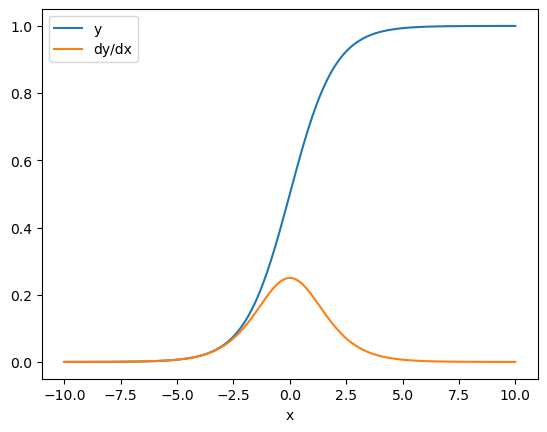

In [58]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

In [59]:
%%markdown
## Control flow

Because a gradient tape records operations as they are executed
, Python control flow is naturally handled (for example, `if` and `while` statements).

Here a different variable is used on each branch of an if. The gradient only connects to the variable that was used:

## Control flow

Because a gradient tape records operations as they are executed
, Python control flow is naturally handled (for example, `if` and `while` statements).

Here a different variable is used on each branch of an if. The gradient only connects to the variable that was used:


In [62]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    if x > 0.0:
        result = v0
    else:
        result = v1 ** 2

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


In [63]:
%%markdown
Just remember that the control statements themselves are not differentiable
, so they are invisible to gradient-based optimizers.

Depending on the value of `x` in the above example, the tape either records `result = v0` or `result = v1**2`.
The gradient with respect to `x` is always `None`.

Just remember that the control statements themselves are not differentiable
, so they are invisible to gradient-based optimizers.

Depending on the value of `x` in the above example, the tape either records `result = v0` or `result = v1**2`.
The gradient with respect to `x` is always `None`.


In [64]:
dx = tape.gradient(result, x)

print(dx)

None


In [66]:
%%markdown
## Cases where `gradient` returns `None`

When a target is not connected to a source, gradient will return `None`.

## Cases where `gradient` returns `None`

When a target is not connected to a source, gradient will return `None`.


In [68]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
    z = y * y
print(tape.gradient(z, x))

None


In [69]:
%%markdown
Here `z` is obviously not connected to `x`, but there are several less-obvious ways that a gradient can be disconnected.

### 1. Replaced a `variable` with a `tensor`

In the section on `"controlling what the tape watches"` you saw that
the tape will automatically watch a `tf.Variable` but not a `tf.Tensor`.

One common error is to inadvertently replace a `tf.Variable` with a `tf.Tensor`
, instead of using `Variable.assign` to update the `tf.Variable`.
Here is an example:

Here `z` is obviously not connected to `x`, but there are several less-obvious ways that a gradient can be disconnected.

### 1. Replaced a `variable` with a `tensor`

In the section on `"controlling what the tape watches"` you saw that
the tape will automatically watch a `tf.Variable` but not a `tf.Tensor`.

One common error is to inadvertently replace a `tf.Variable` with a `tf.Tensor`
, instead of using `Variable.assign` to update the `tf.Variable`.
Here is an example:


In [85]:
x = tf.Variable(2.0)
p = tf.Variable(3.0)

for epoch in range(2):
    print(f"Epoch - {epoch}")
    with tf.GradientTape() as tape:
        y = x + 1

    print(type(x).__name__, ":", tape.gradient(y, x))
    x = x + 1   # This should be `x.assign_add(1)` - shown below
print('-' * 50)
for epoch in range(2):
    print(f"Epoch - {epoch}")
    with tf.GradientTape() as tape:
        q = p * 1

    print(type(x).__name__, ":", tape.gradient(q, p))
    p.assign_add(1)

Epoch - 0
ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
Epoch - 1
EagerTensor : None
--------------------------------------------------
Epoch - 0
EagerTensor : tf.Tensor(1.0, shape=(), dtype=float32)
Epoch - 1
EagerTensor : tf.Tensor(1.0, shape=(), dtype=float32)


In [86]:
%%markdown
### 2. Did calculations outside of `TensorFlow`
The tape can't record the gradient path if the calculation exits outside `TensorFlow`. For example:

### 2. Did calculations outside of `TensorFlow`
The tape can't record the gradient path if the calculation exits outside `TensorFlow`. For example:


In [87]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
    x2 = x ** 2

    # This step is calculated with NumPy
    y = np.mean(x2, axis=0)

    # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
    # using `tf.convert_to_tensor`.
    y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


In [88]:
%%markdown
### 3. Took gradients through an integer or string

`Integers` and `strings` are not differentiable.
If a calculation path uses these data types there will be no gradient.

Nobody expects strings to be differentiable
, but it's easy to accidentally create an `int` constant or variable if you don't specify the `dtype`.

### 3. Took gradients through an integer or string

`Integers` and `strings` are not differentiable.
If a calculation path uses these data types there will be no gradient.

Nobody expects strings to be differentiable
, but it's easy to accidentally create an `int` constant or variable if you don't specify the `dtype`.


In [93]:
x = tf.constant(10)

with tf.GradientTape() as g:
    g.watch(x)
    y = x * x

print(g.gradient(y, x))

None


In [94]:
%%markdown
### 4. Took gradients through a stateful object

`State stops gradients`. When you read from a stateful object
, the tape can only observe the current state, not the history that lead to it.

A `tf.Tensor` is immutable. You can't change a tensor once it's created.
It has a value, but no state. All the operations discussed so far are also stateless:
    the output of a `tf.matmul` only depends on its inputs.

A `tf.Variable` has internal state—its value. When you use the variable, the state is read.
It's normal to calculate a gradient with respect to a variable
, but the variable's state blocks gradient calculations from going farther back. For example:

### 4. Took gradients through a stateful object

`State stops gradients`. When you read from a stateful object
, the tape can only observe the current state, not the history that lead to it.

A `tf.Tensor` is immutable. You can't change a tensor once it's created.
It has a value, but no state. All the operations discussed so far are also stateless:
    the output of a `tf.matmul` only depends on its inputs.

A `tf.Variable` has internal state—its value. When you use the variable, the state is read.
It's normal to calculate a gradient with respect to a variable
, but the variable's state blocks gradient calculations from going farther back. For example:


In [98]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape(persistent=True) as tape:
  # Update x1 = x1 + x0.
  x1.assign_add(x0)
  # The tape starts recording from x1.
  y = x1 ** 2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)
print(tape.gradient(y, x1))   #dy/dx0 = 2*(x1 + x0)

None
tf.Tensor(6.0, shape=(), dtype=float32)


In [99]:
%%markdown
Similarly, `tf.data.Dataset` iterators and `tf.queues` are stateful
, and will stop all gradients on tensors that pass through them.

Similarly, `tf.data.Dataset` iterators and `tf.queues` are stateful
, and will stop all gradients on tensors that pass through them.


In [100]:
%%markdown
## No gradient registered

Some `tf.Operations` are registered as being non-differentiable and will return None
. Others have no gradient registered.

The `tf.raw_ops` page shows which low-level ops have gradients registered.

If you attempt to take a gradient through a float op that has no gradient registered
the tape will throw an error instead of silently returning None.
This way you know something has gone wrong.

For example, the `tf.image.adjust_contrast` function wraps `raw_ops.AdjustContrastv2`
, which could have a gradient but the gradient is not implemented:

## No gradient registered

Some `tf.Operations` are registered as being non-differentiable and will return None
. Others have no gradient registered.

The `tf.raw_ops` page shows which low-level ops have gradients registered.

If you attempt to take a gradient through a float op that has no gradient registered
the tape will throw an error instead of silently returning None.
This way you know something has gone wrong.

For example, the `tf.image.adjust_contrast` function wraps `raw_ops.AdjustContrastv2`
, which could have a gradient but the gradient is not implemented:


In [101]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
    new_image = tf.image.adjust_contrast(image, delta)

try:
    print(tape.gradient(new_image, [image, delta]))
    assert False   # This should not happen.
except LookupError as e:
    print(f'{type(e).__name__}: {e}')

LookupError: gradient registry has no entry for: AdjustContrastv2


In [102]:
%%markdown

If you need to differentiate through this op
, you'll either need to implement the gradient and register it (using `tf.RegisterGradient`)
or re-implement the function using other ops.


If you need to differentiate through this op
, you'll either need to implement the gradient and register it (using `tf.RegisterGradient`)
or re-implement the function using other ops.


In [103]:
%%markdown
## Zeros instead of None

In some cases it would be convenient to get 0 instead of None for unconnected gradients.
You can decide what to return when you have unconnected gradients using the `unconnected_gradients` argument:

## Zeros instead of None

In some cases it would be convenient to get 0 instead of None for unconnected gradients.
You can decide what to return when you have unconnected gradients using the `unconnected_gradients` argument:


In [104]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
    z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
